In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [115]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [5]:
path = 'C:\\Users\\ameen\\Downloads\\nasdaq100-1min\\nasdaq100\\2017\\20170103\\AAL.csv.gz'

data = pd.read_csv(path, nrows=100, compression='gzip',
                   error_bad_lines=False)
data.columns

C:\Users\ameen\AppData\Local\Temp\ipykernel_11056\697656518.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(path, nrows=100, compression='gzip',


Index(['Date', 'Ticker', 'TimeBarStart', 'OpenBarTime', 'OpenBidPrice',
       'OpenBidSize', 'OpenAskPrice', 'OpenAskSize', 'FirstTradeTime',
       'FirstTradePrice', 'FirstTradeSize', 'HighBidTime', 'HighBidPrice',
       'HighBidSize', 'HighAskTime', 'HighAskPrice', 'HighAskSize',
       'HighTradeTime', 'HighTradePrice', 'HighTradeSize', 'LowBidTime',
       'LowBidPrice', 'LowBidSize', 'LowAskTime', 'LowAskPrice', 'LowAskSize',
       'LowTradeTime', 'LowTradePrice', 'LowTradeSize', 'CloseBarTime',
       'CloseBidPrice', 'CloseBidSize', 'CloseAskPrice', 'CloseAskSize',
       'LastTradeTime', 'LastTradePrice', 'LastTradeSize', 'MinSpread',
       'MaxSpread', 'CancelSize', 'VolumeWeightPrice', 'NBBOQuoteCount',
       'TradeAtBid', 'TradeAtBidMid', 'TradeAtMid', 'TradeAtMidAsk',
       'TradeAtAsk', 'TradeAtCrossOrLocked', 'Volume', 'TotalTrades',
       'FinraVolume', 'FinraVolumeWeightPrice', 'UptickVolume',
       'DowntickVolume', 'RepeatUptickVolume', 'RepeatDowntickVolume'

In [24]:
tcols = ['openbartime', 
         'firsttradetime',
         'highbidtime', 
         'highasktime', 
         'hightradetime',
         'lowbidtime', 
         'lowasktime', 
         'lowtradetime',
         'closebartime', 
         'lasttradetime']

drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

keep = ['firsttradeprice', 
        'hightradeprice', 
        'lowtradeprice', 
        'lasttradeprice', 
        'minspread', 
        'maxspread',
        'volumeweightprice', 
        'nbboquotecount', 
        'tradeatbid', 
        'tradeatbidmid', 
        'tradeatmid', 
        'tradeatmidask', 
        'tradeatask', 
        'volume', 
        'totaltrades', 
        'finravolume', 
        'finravolumeweightprice', 
        'uptickvolume', 
        'downtickvolume', 
        'repeatuptickvolume', 
        'repeatdowntickvolume', 
        'tradetomidvolweight', 
        'tradetomidvolweightrelative']

columns = {'volumeweightprice'          : 'price',
           'finravolume'                : 'fvolume',
           'finravolumeweightprice'     : 'fprice',
           'uptickvolume'               : 'up',
           'downtickvolume'             : 'down',
           'repeatuptickvolume'         : 'rup',
           'repeatdowntickvolume'       : 'rdown',
           'firsttradeprice'            : 'first',
           'hightradeprice'             : 'high',
           'lowtradeprice'              : 'low',
           'lasttradeprice'             : 'last',
           'nbboquotecount'             : 'nbbo',
           'totaltrades'                : 'ntrades',
           'openbidprice'               : 'obprice',
           'openbidsize'                : 'obsize',
           'openaskprice'               : 'oaprice',
           'openasksize'                : 'oasize',
           'highbidprice'               : 'hbprice',
           'highbidsize'                : 'hbsize',
           'highaskprice'               : 'haprice',
           'highasksize'                : 'hasize',
           'lowbidprice'                : 'lbprice',
           'lowbidsize'                 : 'lbsize',
           'lowaskprice'                : 'laprice',
           'lowasksize'                 : 'lasize',
           'closebidprice'              : 'cbprice',
           'closebidsize'               : 'cbsize',
           'closeaskprice'              : 'caprice',
           'closeasksize'               : 'casize',
           'firsttradesize'             : 'firstsize',
           'hightradesize'              : 'highsize',
           'lowtradesize'               : 'lowsize',
           'lasttradesize'              : 'lastsize',
           'tradetomidvolweight'        : 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

In [29]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'])
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')
    data.to_excel(nasdaq_path /'algoseek.xlsx', sheet_name='sheet1')

In [30]:
nasdaq_path = Path('C:\\Users\\ameen\\Desktop\\gigs\\trading_bot_python_2_april_23\\data')
extract_and_combine_data()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.03it/s]


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 782 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('AAPL', Timestamp('2015-01-02 16:00:00'))
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   obprice        782 non-null    float64
 1   obsize         782 non-null    int16  
 2   oaprice        782 non-null    float64
 3   oasize         782 non-null    int16  
 4   first          782 non-null    float64
 5   firstsize      782 non-null    int32  
 6   hbprice        782 non-null    float64
 7   hbsize         782 non-null    int16  
 8   haprice        782 non-null    float64
 9   hasize         782 non-null    int32  
 10  high           782 non-null    float64
 11  highsize       782 non-null    int32  
 12  lbprice        782 non-null    float64
 13  lbsize         782 non-null    int32  
 14  laprice        782 non-null    float64
 15  lasize         782 non-null    int32  
 16  low            782 

# Loading the Data Sets from the API:

In [221]:
columns_rename = {'time':'datetime','open':'first','high':'high','low':'low','close':'last','volume':'volume'}

In [220]:
def check_na(df):
    for col in df:
        print("count of NA values in",col,":",str(df[col].isnull().sum()))
        print("\n")

def check_unique(df):
    for col in df:
        print("unique values in",col,":",str(df[col].unique()))
        print("\n")
        
def convert_float(df,col_list):
    for i in col_list:
        df[i] = df[i].astype('float')

def intra_day():
    import pandas as pd
    import requests
    import csv
    # Prompt the user for input
    symbols = input('Enter symbols separated by commas: ').split(',')
    dfs = []
    for symbol in symbols:
        url = 'https://www.alphavantage.co/query'
        params = {
            'function': 'TIME_SERIES_INTRADAY',
            'symbol': symbol,
            'interval': '1min',
            'apikey': 'OX2BPYPUY81XL6PJ',
            'outputsize': 'full',  # Include full historical data
            'start_date': '2022-03-01',  # Set the start date
            'end_date': '2022-03-01'  # Set the end date
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            # Convert the data to a DataFrame
            df = pd.DataFrame.from_dict(data['Time Series (1min)'], orient='index')
            df = df.reset_index()
            df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.sort_values('datetime')
            df['symbol'] = symbol  # Add a new column with the symbol
            df['fwd1min'] = df['close'].shift(-1)  # Add a new column with the 1-minute forward price
            dfs.append(df)
        else:
            print(f'Request failed with status code {response.status_code}')
    data = pd.concat(dfs, ignore_index = True)
    return(data)
    
def api_intra_day_extended():
    import requests
    import csv
    import pandas as pd
    
    symbols = input('Enter symbols separated by commas: ').split(',')
    year = [1, 2]
    months = list(range(1, 13))
    
    permutations = len(symbols) * len(year) * len(months)
    i = 1
    
    dfs = []
    for symbol in symbols:
        for y in year:
            for m in months:
                print('progress:' + str(round(i*100/permutations,2)) + '%')
                i += 1
                url = 'https://www.alphavantage.co/query'
                slice_key = 'year'+str(y)+'month'+str(m)
                params = {
                    'function': 'TIME_SERIES_INTRADAY_EXTENDED',
                    'symbol': symbol,
                    'interval': '1min',
                    'apikey': 'OX2BPYPUY81XL6PJ',
                    'slice': slice_key
                    #'outputsize': 'full',  # Include full historical data
                }
                response = requests.get(url, params=params)
    
                with requests.Session() as s:
                    download = s.get(url,params=params)
                    decoded_content = download.content.decode('utf-8')
                    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                    data = list(cr)
                    df = pd.DataFrame(data[1:], columns=data[0])  # Create pandas DataFrame
                    df['ticker'] = symbol  # Add symbol column to DataFrame
                    dfs.append(df)  # Append DataFrame to list of DataFrames
    
        data = pd.concat(dfs)  # Combine list of DataFrames into one DataFrame
        
        ## ADD DATA SANITY CHECKS HERE:
        # Comparison of total days vs. days fetched.
        # Comparison of count before and after dropping NAs. 
        
        data = (data.drop(['{'],axis=1)
                .dropna()
                .rename(columns=columns_rename))
        data['datetime'] = pd.to_datetime(data['datetime'])
        data['date'] = data['datetime']
        convert_float(data,['first','low','last','volume','high'])
        data = data.set_index(['ticker','datetime'])
        data = data.dropna()
        return(data)

In [222]:
df = api_intra_day_extended()

Enter symbols separated by commas: GOOGL
progress:4.17%
progress:8.33%
progress:12.5%
progress:16.67%
progress:20.83%
progress:25.0%
progress:29.17%
progress:33.33%
progress:37.5%
progress:41.67%
progress:45.83%
progress:50.0%
progress:54.17%
progress:58.33%
progress:62.5%
progress:66.67%
progress:70.83%
progress:75.0%
progress:79.17%
progress:83.33%
progress:87.5%
progress:91.67%
progress:95.83%
progress:100.0%


In [225]:
print(df['date'].min())
print(df['date'].max())
df.info()

## issue: returning only 1 years data

2022-02-07 07:02:00
2023-03-31 20:00:00
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54747 entries, ('GOOGL', Timestamp('2023-03-31 20:00:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   first   54747 non-null  float64       
 1   high    54747 non-null  float64       
 2   low     54747 non-null  float64       
 3   last    54747 non-null  float64       
 4   volume  54747 non-null  float64       
 5   date    54747 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.2+ MB


# Feature Engineering

In [262]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

In [263]:
data = pd.DataFrame(index=df.index)

In [264]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [265]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54747 entries, ('GOOGL', Timestamp('2023-03-31 20:00:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    54747 non-null  int64
dtypes: int64(1)
memory usage: 5.1+ MB


In [266]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('datetime').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

## Lagged Returns

In [269]:
data['ret1min'] = df['last'].div(df['first']).sub(1)
data['ret2min'] = df['last'].div(df['first'].shift(1)).sub(1)
data['ret3min'] = df['last'].div(df['first'].shift(2)).sub(1)
data['ret4min'] = df['last'].div(df['first'].shift(3)).sub(1)
data['ret5min'] = df['last'].div(df['first'].shift(4)).sub(1)
data['ret6min'] = df['last'].div(df['first'].shift(5)).sub(1)
data['ret7min'] = df['last'].div(df['first'].shift(6)).sub(1)
data['ret8min'] = df['last'].div(df['first'].shift(7)).sub(1)
data['ret9min'] = df['last'].div(df['first'].shift(8)).sub(1)
data['ret10min'] = df['last'].div(df['first'].shift(9)).sub(1)

In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54747 entries, ('GOOGL', Timestamp('2023-03-31 20:00:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      54747 non-null  int64  
 1   minute    54747 non-null  int32  
 2   ret1min   54747 non-null  float64
 3   ret2min   54746 non-null  float64
 4   ret3min   54745 non-null  float64
 5   ret4min   54744 non-null  float64
 6   ret5min   54743 non-null  float64
 7   ret6min   54742 non-null  float64
 8   ret7min   54741 non-null  float64
 9   ret8min   54740 non-null  float64
 10  ret9min   54739 non-null  float64
 11  ret10min  54738 non-null  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 9.5+ MB


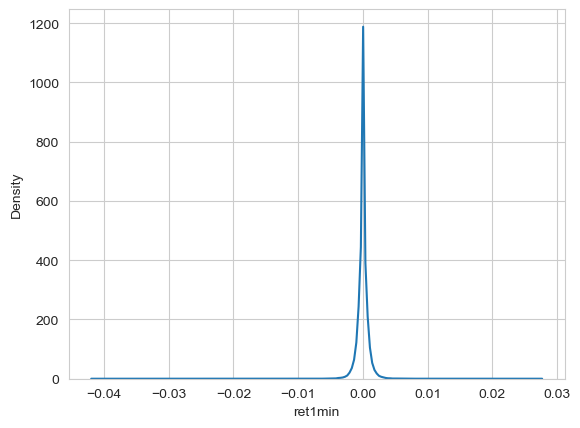

In [255]:
sns.kdeplot(data.ret1min);

In [234]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean    -0.001%
std      0.093%
min     -4.167%
10%     -0.083%
20%     -0.044%
30%     -0.021%
40%     -0.003%
50%      0.000%
60%      0.000%
70%      0.020%
80%      0.043%
90%      0.080%
max      2.738%
Name: ret1min, dtype: object

In [235]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: -2.40 | Kurtosis: 153.13


In [270]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

date  minute   ret1min   ret2min   ret3min  \
ticker datetime                                                           
GOOGL  2023-02-02 16:03:00  26154     722  0.027378  0.001810  0.025095   
       2023-03-15 08:03:00  45972     242  0.022801  0.021694  0.021138   
       2023-03-15 08:02:00  45971     241  0.019640  0.020304  0.019200   
       2023-03-15 08:01:00  45970     240  0.014130  0.017101  0.017763   
       2022-02-14 08:01:00   2073     240  0.013896  0.002174 -0.001034   
       2023-02-02 16:05:00  26156     724  0.013652  0.000496  0.019221   
       2023-02-03 08:01:00  26554     240  0.013593  0.000479  0.000383   
       2023-02-02 16:08:00  26159     727  0.013275 -0.001130  0.017648   
       2023-03-17 04:01:00  47340       0  0.011512  0.000599 -0.000798   
       2023-02-06 08:01:00  27277     240  0.011115  0.001044  0.007024   

                             ret4min   ret5min   ret6min   ret7min   ret8min  \
ticker datetime                                                                
GOOGL  2023-02-02 16:03:00  0.011791  0.030726  0.057206  0.042177  0.061769   
       2023-03-15 08:03:00  0.020585  0.020489  0.019922  0.019922  0.019922   
       2023-03-15 08:02:00  0.018645  0.018093  0.017997  0.017432  0.017432   
       2023-03-15 08:01:00  0.016662  0.016108  0.015558  0.015462  0.014898   
       2022-02-14 08:01:00  0.003297  0.003334  0.006340  0.006344  0.005926   
       2023-02-02 16:05:00  0.045404  0.030543  0.049917  0.064828  0.057524   
       2023-02-03 08:01:00  0.000000 -0.000287  0.000000  0.000479  0.000767   
       2023-02-02 16:08:00  0.032101  0.025022  0.023835  0.025319  0.025220   
       2023-03-17 04:01:00  0.000499  0.001700  0.000499 -0.002490 -0.003085   
       2023-02-06 08:01:00  0.008384  0.008481  0.007995  0.008871  0.008871   

                             ret9min  ret10min      first       last  
ticker datetime                                                       
GOOGL  2023-02-02 16:03:00  0.076848  0.069462  107.75000  110.70000  
       2023-03-15 08:03:00  0.019150  0.019370   92.10000   94.20000  
       2023-03-15 08:02:00  0.017432  0.016661   92.16000   93.97000  
       2023-03-15 08:01:00  0.014898  0.014898   92.43000   93.73600  
       2022-02-14 08:01:00  0.002922  0.002922  132.50025  134.34141  
       2023-02-02 16:05:00  0.056299  0.057830  107.99000  109.46430  
       2023-02-03 08:01:00  0.000000  0.000096  102.99990  104.40000  
       2023-02-02 16:08:00  0.032603  0.033106  104.71000  106.10000  
       2023-03-17 04:01:00 -0.002191 -0.002887   99.03000  100.17000  
       2023-02-06 08:01:00  0.009553  0.009554  103.37000  104.51900

In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54747 entries, ('GOOGL', Timestamp('2023-03-31 20:00:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      54747 non-null  int64  
 1   minute    54747 non-null  int32  
 2   ret1min   54747 non-null  float64
 3   ret2min   54746 non-null  float64
 4   ret3min   54745 non-null  float64
 5   ret4min   54744 non-null  float64
 6   ret5min   54743 non-null  float64
 7   ret6min   54742 non-null  float64
 8   ret7min   54741 non-null  float64
 9   ret8min   54740 non-null  float64
 10  ret9min   54739 non-null  float64
 11  ret10min  54738 non-null  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 9.5+ MB


## Forward Returns

In [272]:
data['fwd1min'] = (data.sort_index())['ret1min'].shift(-1)

In [273]:
data = data.dropna(subset=['fwd1min'])

In [274]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54746 entries, ('GOOGL', Timestamp('2023-03-31 19:59:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      54746 non-null  int64  
 1   minute    54746 non-null  int32  
 2   ret1min   54746 non-null  float64
 3   ret2min   54746 non-null  float64
 4   ret3min   54745 non-null  float64
 5   ret4min   54744 non-null  float64
 6   ret5min   54743 non-null  float64
 7   ret6min   54742 non-null  float64
 8   ret7min   54741 non-null  float64
 9   ret8min   54740 non-null  float64
 10  ret9min   54739 non-null  float64
 11  ret10min  54738 non-null  float64
 12  fwd1min   54746 non-null  float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 7.9+ MB


In [284]:
df.tail()

first      high       low      last   volume  \
ticker datetime                                                               
GOOGL  2022-02-07 07:47:00  144.0500  144.0500  144.0500  144.0500   4320.0   
       2022-02-07 07:07:00  144.0235  144.0235  144.0235  144.0235   6200.0   
       2022-02-07 07:06:00  143.7925  143.7925  143.7925  143.7925   9880.0   
       2022-02-07 07:04:00  143.7005  143.7005  143.7005  143.7005  14160.0   
       2022-02-07 07:02:00  143.7500  143.7500  143.7500  143.7500  11180.0   

                                          date  
ticker datetime                                 
GOOGL  2022-02-07 07:47:00 2022-02-07 07:47:00  
       2022-02-07 07:07:00 2022-02-07 07:07:00  
       2022-02-07 07:06:00 2022-02-07 07:06:00  
       2022-02-07 07:04:00 2022-02-07 07:04:00  
       2022-02-07 07:02:00 2022-02-07 07:02:00

## Other Technical Features:

In [279]:
data['BOP'] = talib.BOP(df['first'],df['high'],df['low'],df['last'])

In [285]:
data['CCI'] = talib.CCI(df.high,df.low,df['last'],timeperiod=14)

In [287]:
data['MFI'] = talib.MFI(df.high,df.low,df['last'],df.volume,timeperiod=14)

In [289]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,54746.000000,54734.000000,5.473300e+04
mean,-0.007702,1.256680,5.025997e+01
std,0.635975,107.939502,1.813591e+01
min,-1.000000,-466.666667,-8.890707e-14
10%,-0.998543,-136.496334,2.676836e+01
20%,-0.682927,-99.191596,3.461263e+01
30%,-0.394698,-68.369213,4.045967e+01
40%,-0.058824,-36.692506,4.556832e+01
50%,0.000000,1.244622,5.028034e+01
60%,0.018182,39.082119,5.490548e+01


In [290]:
data['STOCHRSI'] = talib.STOCHRSI(df['last'].ffill(),timeperiod=14,fastk_period=14,fastd_period=3,fastd_matype=0)[0]

In [292]:
fastk_period=14
slowk_period=3
slowk_matype=0
slowd_period=3
slowd_matype=0
data['slowk'], data['slowd'] = talib.STOCH(df.high.ffill(), df.low.ffill(), df['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)

In [294]:
data['NATR'] = talib.NATR(df.high.ffill(),df.low.ffill(),df['last'].ffill())

In [296]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54746 entries, ('GOOGL', Timestamp('2023-03-31 19:59:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      54746 non-null  int64  
 1   minute    54746 non-null  int32  
 2   ret1min   54746 non-null  float64
 3   ret2min   54746 non-null  float64
 4   ret3min   54745 non-null  float64
 5   ret4min   54744 non-null  float64
 6   ret5min   54743 non-null  float64
 7   ret6min   54742 non-null  float64
 8   ret7min   54741 non-null  float64
 9   ret8min   54740 non-null  float64
 10  ret9min   54739 non-null  float64
 11  ret10min  54738 non-null  float64
 12  fwd1min   54746 non-null  float64
 13  BOP       54746 non-null  float64
 14  CCI       54734 non-null  float64
 15  MFI       54733 non-null  float64
 16  STOCHRSI  54718 non-null  float64
 17  slowk     54730 non-null  float64
 18  slowd     54730 non-null  

# Evaluate features

In [297]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min','BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd']

In [299]:
sample = data.sample(n=20000)

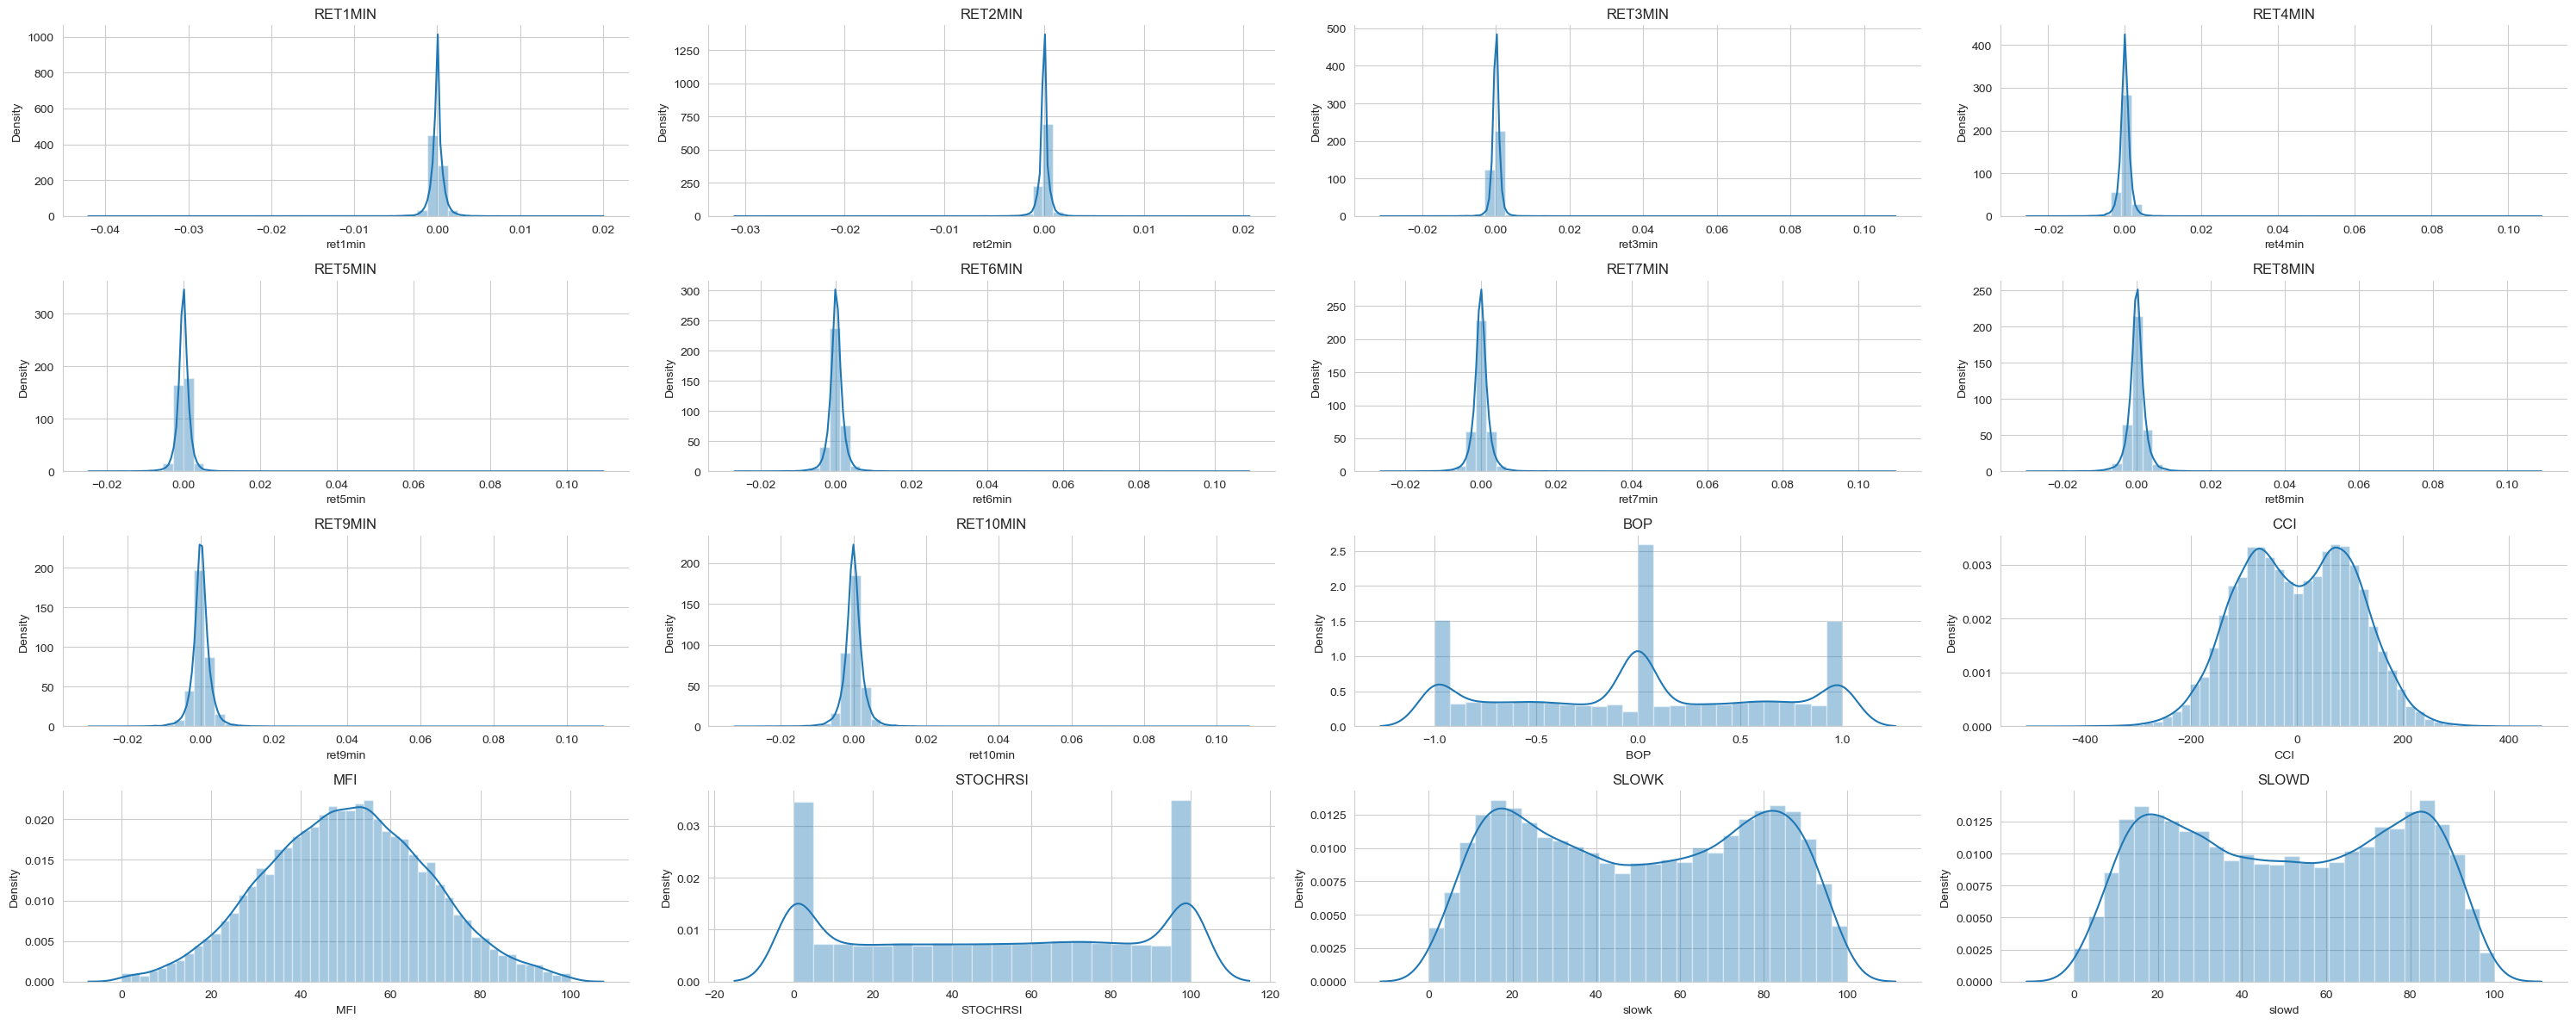

In [301]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

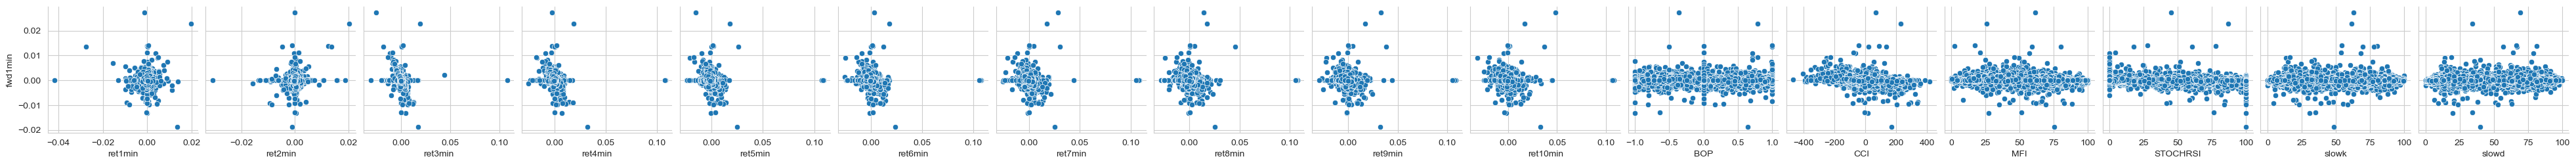

In [302]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features)

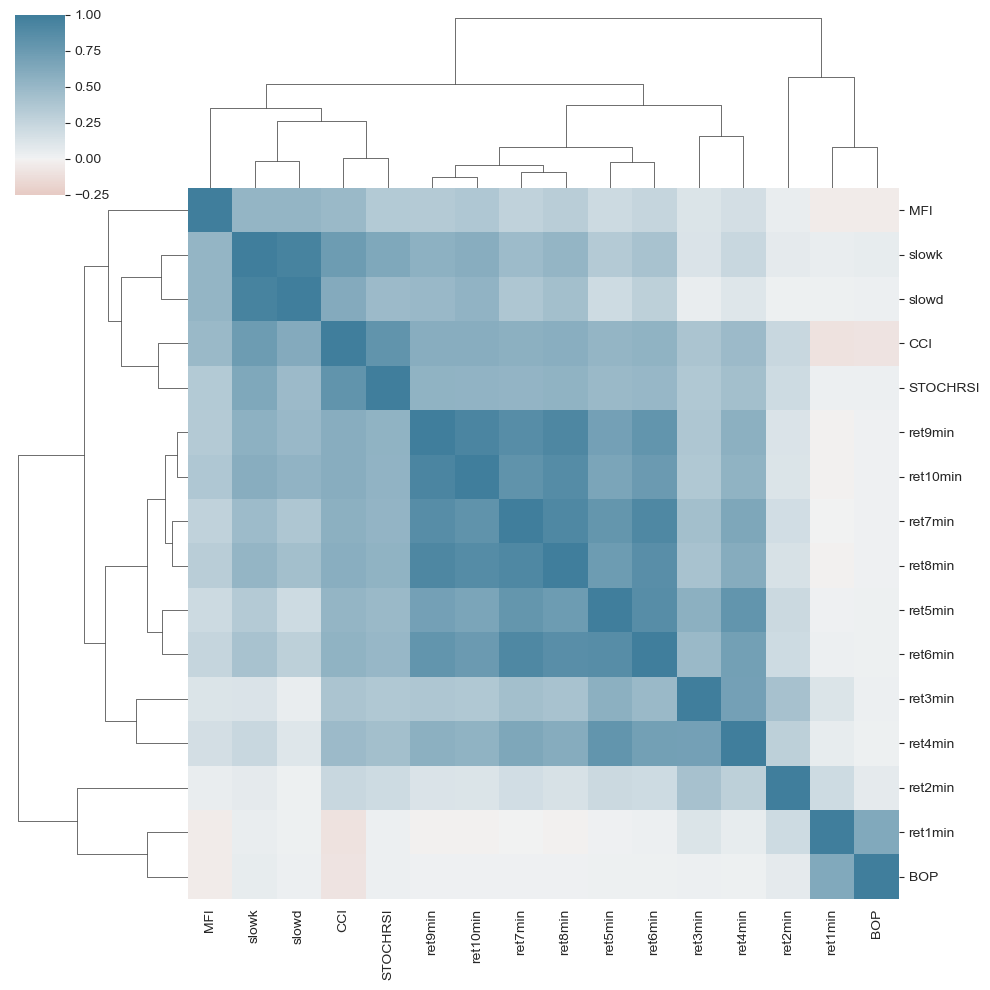

In [303]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [305]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('datetime').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.50it/s]


In [306]:
ic.sort_values()

ret3min    -0.653713
ret4min    -0.477917
STOCHRSI   -0.405627
ret5min    -0.393515
CCI        -0.370981
ret6min    -0.337471
ret7min    -0.304022
ret8min    -0.280333
ret9min    -0.261503
ret10min   -0.244341
MFI        -0.148390
slowk      -0.060532
slowd       0.004550
BOP         0.010980
ret1min     0.014555
ret2min     0.022396
dtype: float64

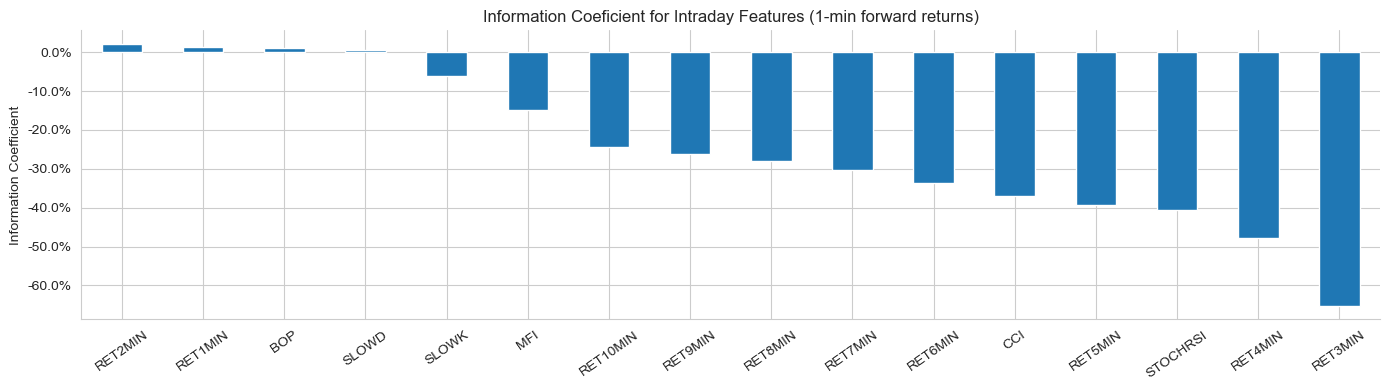

In [307]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

In [308]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54746 entries, ('GOOGL', Timestamp('2023-03-31 19:59:00')) to ('GOOGL', Timestamp('2022-02-07 07:02:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      54746 non-null  int64  
 1   minute    54746 non-null  int32  
 2   ret1min   54746 non-null  float64
 3   ret2min   54746 non-null  float64
 4   ret3min   54745 non-null  float64
 5   ret4min   54744 non-null  float64
 6   ret5min   54743 non-null  float64
 7   ret6min   54742 non-null  float64
 8   ret7min   54741 non-null  float64
 9   ret8min   54740 non-null  float64
 10  ret9min   54739 non-null  float64
 11  ret10min  54738 non-null  float64
 12  fwd1min   54746 non-null  float64
 13  BOP       54746 non-null  float64
 14  CCI       54734 non-null  float64
 15  MFI       54733 non-null  float64
 16  STOCHRSI  54718 non-null  float64
 17  slowk     54730 non-null  float64
 18  slowd     54730 non-null  

In [309]:
path = 'C:/Users/ameen/Desktop/gigs/trading_bot_python_2_april_23'
data.drop(['date'], axis=1).to_csv(path + '/dataset.csv')